# Implementation benchmarks

In [15]:
import time
from functools import partial
import torch
import plotly.graph_objects as go
import pandas as pd

def time_runs(fn, num = 100):
    s = time.time()
    for _ in range(num):
        fn()
    return time.time() - s

### `_scaled_dot_product_attention`

In [83]:
from modules.mha import _scaled_dot_product_attention

B = 1 # batch_size
seq_lens = [10, 25, 100, 250, 1000, 2500, 10000] 
embed_sizes = [10, 25, 100, 250, 1000, 2500]

# results = []

for N in seq_lens:
    for E in embed_sizes:
        print(f"N = {N}, E = {E}")
        q = torch.randn((B, N, E))
        k = torch.randn((B, N, E))
        v = torch.randn((B, N, E))
        
        timing = time_runs(
            partial(
                _scaled_dot_product_attention,
                q = q,
                k = k,
                v = v,
            )
        )
        results.append((N,E,timing))
        
print("Done!")
df = pd.DataFrame(results, columns=['N', 'E', 'T'])
df

N = 10000, E = 10
N = 10000, E = 25
N = 10000, E = 100
N = 10000, E = 250
N = 10000, E = 1000
N = 10000, E = 2500
Done!


,N,E,T
0,10,10,0.002980
1,10,25,0.002176
2,10,100,0.004220
3,10,250,0.002629
4,10,1000,0.005577
5,10,2500,0.007169
6,25,10,0.002783
7,25,25,0.002840
8,25,100,0.003465
9,25,250,0.003805


### `_scaled_dot_product_attention_step`

In [91]:
from modules.co_mha import _scaled_dot_product_attention_step

B = 1 # batch_size
seq_lens = [10, 25, 100, 250, 1000, 2500, 10000] 
embed_sizes = [10, 25, 100, 250, 1000, 2500]

results_co = []

for N in seq_lens:
    for E in embed_sizes:
        print(f"N = {N}, E = {E}")
        query1 = torch.randn((B, N, E))
        key1 = torch.randn((B, N, E))
        value1 = torch.randn((B, N, E))
        
        query_step = torch.randn((B, E))
        key_step = torch.randn((B, E))
        value_step = torch.randn((B, E))

        query2 = torch.cat((query1[:, 1:], query_step.unsqueeze(1)), dim=1)
        key2 = torch.cat((key1[:, 1:], key_step.unsqueeze(1)), dim=1)
        value2 = torch.cat((value1[:, 1:], value_step.unsqueeze(1)), dim=1)
        
        attn_sum = torch.randn((B, N))
        av = torch.randn((B,N,E))
        
        prev_state = (
            attn_sum[:, 1:],
            av[:, 1:],
            query1,
            key1.transpose(-2, -1),
            value1,
            # 0,
            # 0,
            # 0,
        )
        
        timing = time_runs(
            partial(
                _scaled_dot_product_attention_step,
                prev_state=prev_state,
                q_step=query_step,
                k_step=key_step,
                v_step=value_step,
            )
        )
        results_co.append((N,E,timing))
        
print("Done!")
df_co = pd.DataFrame(results_co, columns=['N', 'E', 'T'])
df_co

N = 10000, E = 10
N = 10000, E = 25
N = 10000, E = 100
N = 10000, E = 250
N = 10000, E = 1000
N = 10000, E = 2500
Done!


,N,E,T
0,10,10,0.025623
1,10,25,0.021128
2,10,100,0.026265
3,10,250,0.020069
4,10,1000,0.026831
5,10,2500,0.038389
6,25,10,0.020943
7,25,25,0.019166
8,25,100,0.024755
9,25,250,0.022048


### Comparison

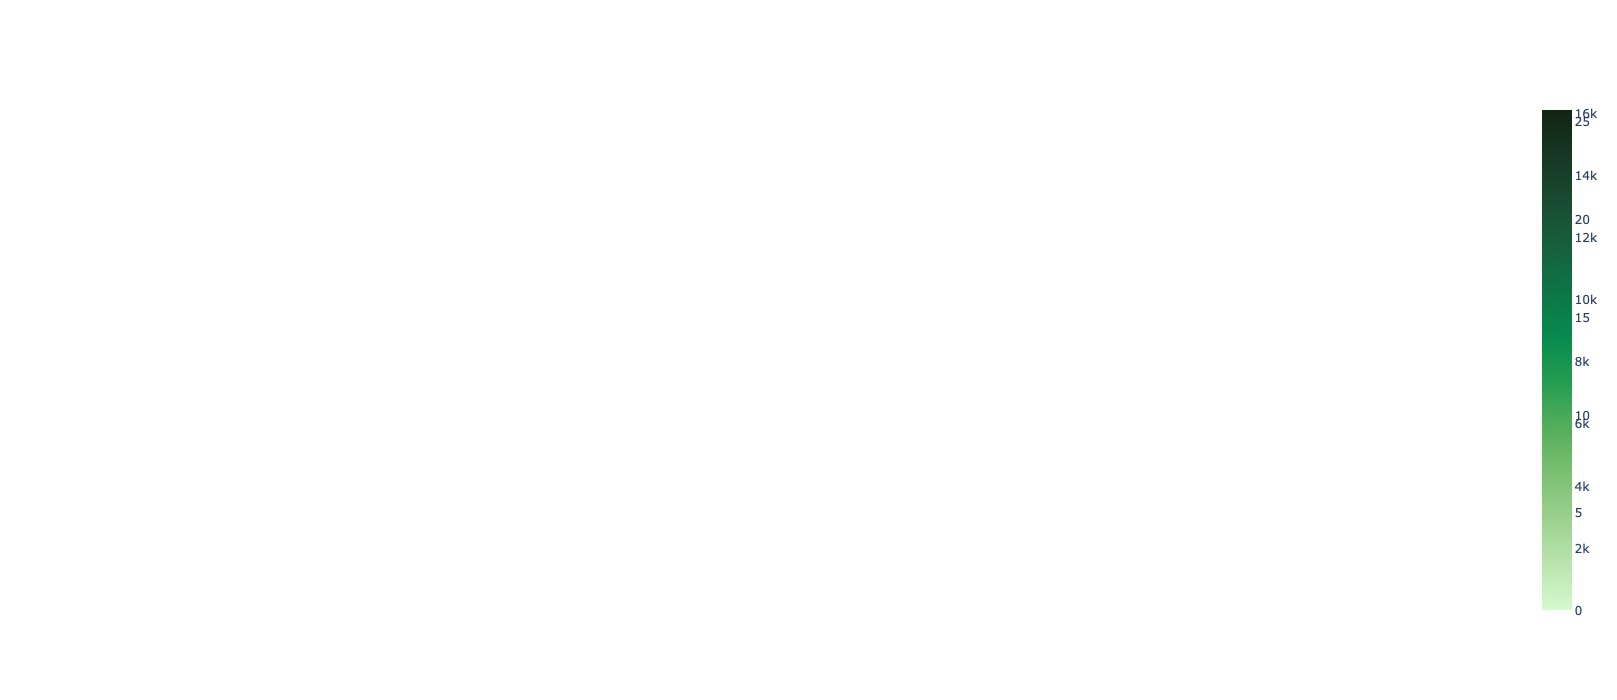

In [92]:
fig = go.Figure(
    data=[
        go.Mesh3d(
            x=df["N"], 
            y=df["E"], 
            z=df["T"], 
            intensity=df["T"], 
            colorscale="agsunset", 
            opacity=0.5,
            contour={"show":True},
        ),
        go.Mesh3d(
            x=df_co["N"], 
            y=df_co["E"], 
            z=df_co["T"], 
            intensity=df_co["T"], 
            colorscale="algae", 
            opacity=0.5,
        )
    ]
)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    scene = dict(
        xaxis_title='Sequence Length',
        yaxis_title='Embed Size',
        zaxis_title='Runtime',
        xaxis_type="log", 
        yaxis_type="log",
        zaxis_type="log",
    ),
    
)
fig.show()

In [93]:
df["T_co"] = df_co["T"]
df["T_fact"] = df["T"] / df_co["T"]
df

,N,E,T,T_co,T_fact
0,10,10,0.002980,0.025623,0.116310
1,10,25,0.002176,0.021128,0.102993
2,10,100,0.004220,0.026265,0.160671
3,10,250,0.002629,0.020069,0.130999
4,10,1000,0.005577,0.026831,0.207850
5,10,2500,0.007169,0.038389,0.186745
6,25,10,0.002783,0.020943,0.132876
7,25,25,0.002840,0.019166,0.148169
8,25,100,0.003465,0.024755,0.139968
9,25,250,0.003805,0.022048,0.172575


## Linear projection
How does the timing scale when the number of elements increases?

In [96]:
x = torch.randn((B, N, E))

lin = torch.nn.Linear(E, E)

In [109]:
from modules.co_mha import _scaled_dot_product_attention_step

B = 1 # batch_size
seq_lens = [1, 10, 25, 100, 250, 1000, 2500, 10000] 
embed_sizes = [10, 25, 100, 250, 1000, 2500]

results_lin = []

for N in seq_lens:
    for E in embed_sizes:
        print(f"N = {N}, E = {E}")
        x = torch.randn((B, N, E))
        lin = torch.nn.Linear(E, E)
        timing = time_runs(
            partial(
                lin.forward,
                input=x,
            )
        )
        results_lin.append((N,E,timing))
        
print("Done!")
df_lin = pd.DataFrame(results_lin, columns=['N', 'E', 'T'])
df_lin

,N,E,T
0,1,10,0.003127
1,1,25,0.002043
2,1,100,0.002476
3,1,250,0.003899
4,1,1000,0.014817
5,1,2500,0.120149
6,10,10,0.003343
7,10,25,0.003395
8,10,100,0.003181
9,10,250,0.005578


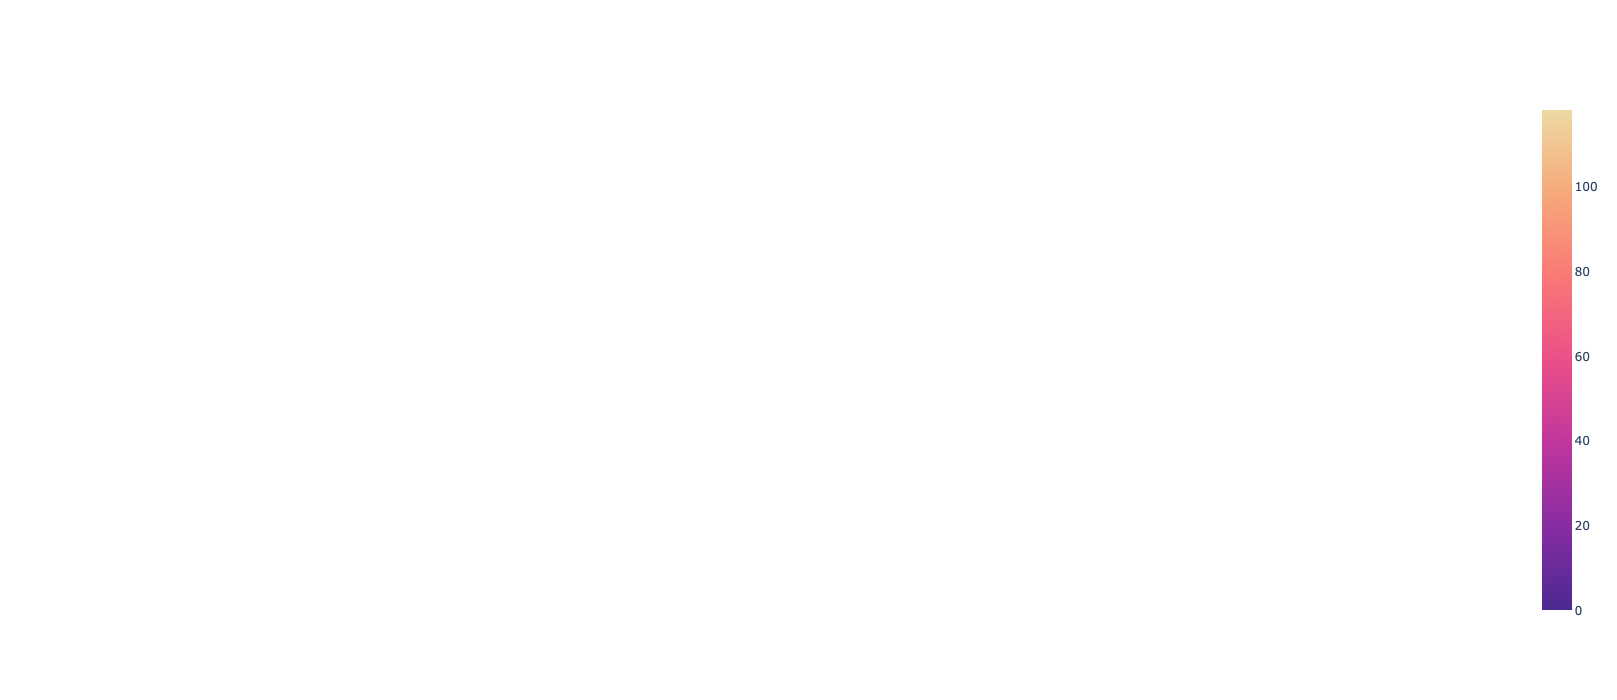

In [111]:
fig = go.Figure(
    data=[
        go.Mesh3d(
            x=df_lin["N"], 
            y=df_lin["E"], 
            z=df_lin["T"], 
            intensity=df_lin["T"], 
            colorscale="agsunset", 
            opacity=0.5,
            contour={"show":True},
        )
    ]
)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    scene = dict(
        xaxis_title='Sequence Length',
        yaxis_title='Embed Size',
        zaxis_title='Runtime',
        xaxis_type="log", 
        yaxis_type="log",
        # zaxis_type="log",
    ),
)
fig.show()

In [131]:
listlist = [
    (df_lin[df_lin["N"] == N]["T"].values / df_lin[df_lin["N"] == 1]["T"].values)
    for N in [1,10,25,100,250,1000,2500,10000]
]

df_lin["RelToN1"] =[item for sublist in listlist for item in sublist]

In [133]:
df_lin

,N,E,T,RelToN1
0,1,10,0.003127,1.000000
1,1,25,0.002043,1.000000
2,1,100,0.002476,1.000000
3,1,250,0.003899,1.000000
4,1,1000,0.014817,1.000000
5,1,2500,0.120149,1.000000
6,10,10,0.003343,1.069076
7,10,25,0.003395,1.661804
8,10,100,0.003181,1.284738
9,10,250,0.005578,1.430598
